In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import seaborn as sb
import nltk
import string
from nltk.stem import PorterStemmer
from numba import vectorize
import unidecode

# 0- Functions & Definitions

#### Function: to load file

In [2]:
#This function will load file and return it as Data Frame and also return list of column names
def loadFile(fileName):
    #reading the temp file to a dataframe with the new headers    
    print('Loading File...',end='')
    result = pd.read_csv(fileName)
    print('[ok]')
    print('Loaded {:,} reviews' .format(len(result)))    
    print('Column Names: ', result.columns.tolist())
    return result, result.columns.tolist()

#### Function: to drop unused columns

In [3]:
#This fuction will return modified dataframe with selected columns only
def neededColumnsOnly(df, columns_needed):
    #return df.filter(columns_needed) 
    #Or
    to_drop_columns = list(x for x in df.columns.tolist() if x not in columns_needed)
    df.drop(to_drop_columns,axis=1,inplace=True)
    return df

#### Function: to find columns containing nulls

In [4]:
#This fuction will check which columns having null values
def columns_with_nulls(df, index_column):
    null_columns = []
    for column in df.columns:
        if column != index_column:
            check_null = df.isnull()[[column,index_column]].groupby(column).agg('count')
            try:
                if check_null.loc[True][0] > 0:
                    null_columns.append(column)
            except:
                pass
    return null_columns

#### Function: to remove all null values from columns

In [5]:
#This fuction will remove all nulls in columns found earlier
def remove_nulls(df, columns):
    for column in columns:
        df[column].fillna('', inplace=True)
    return df

#### Function: to find columns containing html tags

In [6]:
#This fuction will check which columns having html tags
def columns_with_html(df):
    null_columns = []
    for column in df.columns:
        try:
            text_html = df[column].str.find('<')
            text_html = text_html[text_html != -1]
            check_null = len(text_html)
            if check_null > 0:
                null_columns.append(column)
        except:
            pass
    return null_columns

#### Function: to remove html tags from data

In [7]:
#This fuction will remove all html tags in text
def remove_html_tags(text):
    sp = BeautifulSoup(text, "html.parser")
    returned_text = sp.get_text(separator=" ")
    return returned_text

#### Function: to merge Summary and Text in one column and get rid of productId column

In [8]:
#This fuction will result in two columns only score and review
def merge_summary_text(df):
    df['review']=df['Summary']+' '+df['Text'] 
    df.drop(['Summary','Text','ProductId'],axis=1,inplace=True)
    return df

#### Function: to correct accent in letters

In [9]:
#This function will replace accents in letters with regular letters example nescafé will be nescafe
def correct_accent(text):
    returned_text = unidecode.unidecode(text)
    return returned_text

#### Function: to visualized score count

In [10]:
def visualize_score_count(df):
    # visualize total review by score count
    final_df_grouped = df[['Score', 'review']].groupby('Score').agg('count')
    final_df_grouped= final_df_grouped.reset_index()
    f, ax = plt.subplots(figsize=(8, 6))
    fig = sb.barplot(x='Score', y="review", data=final_df_grouped)

# 1- Data Exploration and Visualization:

## 1.1 Data Preparation and Cleaning

#### 1.1.1 Load Data File

In [11]:
# Load Data Set, this will return our main Data set and list of column names

original_df, column_names = loadFile('train.csv')

Loading File...[ok]
Loaded 426,340 reviews
Column Names:  ['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text']


#### 1.1.2 Extract Needed Columns

In [12]:
# Get rid of un needed columns

df_required_columns = neededColumnsOnly(original_df, ['ProductId','Score','Summary','Text'])

In [13]:
df_required_columns.head(10)

,ProductId,Score,Summary,Text
0,B0034EDLS2,5,Very Good,I received this product early from the seller!...
1,B001I7HJE4,5,"Organic, Kosher, Tasty Assortment of Premium T...",*****<br />Numi's Collection Assortment Melang...
2,B000LKTB90,5,"excellent gluten-free spaghetti: great taste, ...","I was very careful not to overcook this pasta,..."
3,B001HXJPS2,5,Lindt is Lindt,Buying this multi-pack I was misled by the pic...
4,B006H34CUS,5,YUM!!!!!,These bars are so good! I loved them warmed up...
5,B004728MI4,5,Delicious,"I love these chips, I buy the 24 pack once a m..."
6,B001BZ5EFE,5,Tastes great and it's organic!!,I'm a huge fan of eating cereal for breakfast....
7,B0001AVRQK,2,Poor taste,I was really disappointed with the Sorghum we ...
8,B005GV9RZC,3,Better than US Instant Coffee,A friend who has gone to Korea gave me a coupl...
9,B004FEN3GK,4,Hard not to like!,No need for plastic baggies or sloppy tin foil...


#### 1.1.3 Remove Nulls

In [14]:
# Get list of columns containing null values

list_columns_with_nulls = columns_with_nulls(df_required_columns, 'ProductId')

In [15]:
list_columns_with_nulls

['Summary']

In [16]:
# Replace null values with empty string

df_without_nulls = remove_nulls(df_required_columns, list_columns_with_nulls)

In [17]:
df_without_nulls.head()

,ProductId,Score,Summary,Text
0,B0034EDLS2,5,Very Good,I received this product early from the seller!...
1,B001I7HJE4,5,"Organic, Kosher, Tasty Assortment of Premium T...",*****<br />Numi's Collection Assortment Melang...
2,B000LKTB90,5,"excellent gluten-free spaghetti: great taste, ...","I was very careful not to overcook this pasta,..."
3,B001HXJPS2,5,Lindt is Lindt,Buying this multi-pack I was misled by the pic...
4,B006H34CUS,5,YUM!!!!!,These bars are so good! I loved them warmed up...


In [18]:
# double check if removed

columns_with_nulls(df_without_nulls, 'ProductId')

[]

#### 1.1.3 Remove Html Tags

In [19]:
# Get list of columns containing html tags

list_columns_with_html = columns_with_html(df_without_nulls)

In [20]:
list_columns_with_html

['Text']

In [21]:
# example of html tag in text column

df_without_nulls.loc[1]['Text']

'*****<br />Numi\'s Collection Assortment Melange includes:<br />5 Herbal Teas (caffeine-free, also called "teasans"):<br />* Dry Desert Lime: Lime Herbal Teasan<br />* Fields of Gold: Lemongrass Herbal Teasan<br />* Red Mellow Bush: Rooibos Herbal Teasan<br />* Bushmen\'s Brew: Honeybush Herbal Teasan<br />* Simply Mint: Moroccan Mint<br /><br />2 Green Teas (lower in caffeine):<br />* Temple of Heaven: Gunpowder Green Tea<br />* Monkey King: Jasmine Green Tea<br /><br />2 Black Teas (contain caffeine):<br />* Chinese Breakfast: Yunnan Black Tea<br />* Smoky Tarry: Lapsang Souchong Black Tea<br /><br />This is a total of nine different teas, two tea bags of each one in each box. Numi teas are known for their high-quality, organic and kosher ingredients, and in my opinion, are some of the tastiest and best teas I have ever tried. They do not include artificial ingredients or flavorings.<br /><br />On the box, the manufacturer writes: "From mist-covered mountains to sun-drenched deserts

In [22]:
df_without_html = df_without_nulls.copy()

In [23]:
# Get rid of html tags 
df_without_html['Text'] = df_without_html['Text'].apply(remove_html_tags)

In [24]:
df_without_html.loc[1]['Text']

'***** Numi\'s Collection Assortment Melange includes: 5 Herbal Teas (caffeine-free, also called "teasans"): * Dry Desert Lime: Lime Herbal Teasan * Fields of Gold: Lemongrass Herbal Teasan * Red Mellow Bush: Rooibos Herbal Teasan * Bushmen\'s Brew: Honeybush Herbal Teasan * Simply Mint: Moroccan Mint 2 Green Teas (lower in caffeine): * Temple of Heaven: Gunpowder Green Tea * Monkey King: Jasmine Green Tea 2 Black Teas (contain caffeine): * Chinese Breakfast: Yunnan Black Tea * Smoky Tarry: Lapsang Souchong Black Tea This is a total of nine different teas, two tea bags of each one in each box. Numi teas are known for their high-quality, organic and kosher ingredients, and in my opinion, are some of the tastiest and best teas I have ever tried. They do not include artificial ingredients or flavorings. On the box, the manufacturer writes: "From mist-covered mountains to sun-drenched deserts to fertile fields, we proudly bring you our tea palette. The flavors range from smooth earthiness,

#### 1.1.4 Merge Summary and Text in review column

In [25]:
# final dataframe preparation

final_df = merge_summary_text(df_without_html)

In [26]:
final_df.head(10)

,Score,review
0,5,Very Good I received this product early from t...
1,5,"Organic, Kosher, Tasty Assortment of Premium T..."
2,5,"excellent gluten-free spaghetti: great taste, ..."
3,5,Lindt is Lindt Buying this multi-pack I was mi...
4,5,YUM!!!!! These bars are so good! I loved them ...
5,5,"Delicious I love these chips, I buy the 24 pac..."
6,5,Tastes great and it's organic!! I'm a huge fan...
7,2,Poor taste I was really disappointed with the ...
8,3,Better than US Instant Coffee A friend who has...
9,4,Hard not to like! No need for plastic baggies ...


##### 1.1.5 Correct accented letters

In [27]:
#check if accent exist
text_html = final_df['review'].str.find('é')
text_html = text_html[text_html != -1]

In [28]:
text_html.head(10)

864       173
3467      371
4554     1236
4590     1494
7852       15
9339      123
10269     107
12255     112
14951    1547
15712      61
Name: review, dtype: int64

In [29]:
final_df['review'].iloc[15712] #nescafé  is found

"not my cup of coffee i bought this becuase i liked the nescafé packets of instant coffee that i got in my hotel room the last time i was in the dominican republic and i'll admit, i don't like coffee. but when i tried this stuff from dominican i was like omg this is a party in my mouth and i'm drinking it black!!! so i bought this nescafé canister hoping it would be the same. well it wasn't. this stuff has nothing to recommend it. it's worse than most coffees i've tried."

In [30]:
#remove accents
final_df['review'] = final_df['review'].apply(correct_accent)

In [31]:
#double check if removed
final_df['review'].iloc[15712]

"not my cup of coffee i bought this becuase i liked the nescafe packets of instant coffee that i got in my hotel room the last time i was in the dominican republic and i'll admit, i don't like coffee. but when i tried this stuff from dominican i was like omg this is a party in my mouth and i'm drinking it black!!! so i bought this nescafe canister hoping it would be the same. well it wasn't. this stuff has nothing to recommend it. it's worse than most coffees i've tried."

In [32]:
final_df.head(10)

,Score,review
0,5,Very Good I received this product early from t...
1,5,"Organic, Kosher, Tasty Assortment of Premium T..."
2,5,"excellent gluten-free spaghetti: great taste, ..."
3,5,Lindt is Lindt Buying this multi-pack I was mi...
4,5,YUM!!!!! These bars are so good! I loved them ...
5,5,"Delicious I love these chips, I buy the 24 pac..."
6,5,Tastes great and it's organic!! I'm a huge fan...
7,2,Poor taste I was really disappointed with the ...
8,3,Better than US Instant Coffee A friend who has...
9,4,Hard not to like! No need for plastic baggies ...


## 1.2 Data Explore and Visualize

#### 1.2.1 Visualize score count

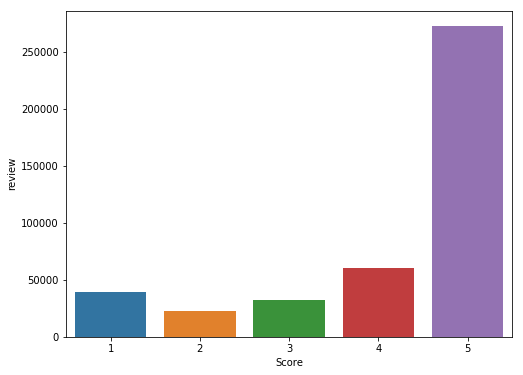

In [33]:
visualize_score_count(final_df)

#### 1.2.2 Describe Score Data

In [34]:
final_df.groupby('Score').describe()

review                                                                
        count  unique                                                top freq
Score                                                                        
1       39193   28530  Filler food is empty, leaves your cat always n...  140
2       22353   16290  Personal preference I had hoped this tea would...   23
3       31993   23301  I'll pass... Not enough flavor, murky brown co...   22
4       60309   43876  Stash Chamomile Herbal Tea Stash Chamomile Her...   30
5      272492  197181  Fantastic Food for Good Cat Health The pet foo...   37

#### 1.2.3 Analyze finding

#### we found that not all are unique. so we investigate further for uniqness

In [35]:
final_df.groupby('review').agg('count')

,Score
review,
"I like the product and tried it before I puchased it. However, one of the boxes arrived have only 10 in it instead of 12.",1
"I only used two maybe three tea bags and got pregnant - can not drink during pregnancy. Not a bad taste, but I'm not a big tea fan either.",18
"This is a cool system only problem is that the coffee is no longer hot once it drains into your cup. If you are using it to make ice coffee though, it's great!",1
"! It's HOT ! This is it, it's the hit at every get together! And YES - Use the spoon that is attached...... you need it! A must have, if you love Hot Sauce!",1
"! Mmmmmmmmmm ! What a wonderful surprise to find LUCY's on Amazon.com! I haven't enjoyed a cookie as much as I enjoy LUCY'S since going gluten free several years ago. They have that just-right crunch. They are just sweet enough - not too, not not. They are just the right size. They have just the right ""mmmmm"" factor. THANK YOU DR. LUCY for sharing the ""lemonade"" you made from the dietary lemons life gave you too! You've given me many appreciated ""mmmmmmm"", ""mmmmmm"", ""mmmmmmm"" moments! Catsy",5
"! WARNING ! Not for those who can't handle the heat! * SAFETY INFORMATION ! WARNING! Risk of death, severe injury, chemical reactions. ------------------------------------------------------------ DO NOT even think of attempting to try a product this hot without being fully prepared. Acclimate yourself over a period of months to truly hot food substances. Keep antidotes on hand such as peanut butter, vodka, ice cream, etc. If the burning sensation is over-powering, place an antidote in your mouth and swirl it around for several minutes. Repeat as necessary. Contact a medical professional for help as needed. ----------------------------------------------------------- * OVERALL REACTION All right, with the Safety info out of the way, I will now delve into the really good news: Woo-hoo! This stuff is HOT! Spicy, yes, indeed -- and GREAT! From time to time I buy Blair's products whenever I see them in a store and now we are blessed to be able to pick them up on the Internet and right here at Amazon, too. This Death Rain Nitro powder is killer! Aaaaaahhh! HELP! Call 9-1-1 and look out! PLEASE please Please PLEASE do NOT attempt to sample any Dath Rain Nitro unless you are a 100% certified psycho Hot Head and can take the Scoville Units way, waaaaaaaaaaaaaaayyyyy up there my friend. YES! If so, then take just a little bit, maybe three or four speckles of the powder, and try it on something. I just now sprinkled some on a spoon of chili that I made last night and after a few seconds, WHOAH! Tremors. Spasms. Internal tsunamis of flavor, shock, heat waves . . . now I am perspiring . . . but lovin' it! Wooooooooooooooooo! Woo-hoo! At first, you may not notice anything and think, ""Hmm. This stuff isn't so hot."" Then, the delayed fuse reaction takes affect . . . and keeps on burning, and burning, and BURNING! Aaaaaahhhh! Ten to fifteen minutes after ingestion, the heat and your own body's reaction will reach an apex so please hang in there, be patient, wait for the results, then consider the full effect, flavor, heat, power, and other attributes of Blair's Death Rain Nitro powder seasoning. Try a little, wait a lot. This is for your own safety, ok, thanks. Wait maybe . . . five to ten minutes. Then decide what Blair's Death Rain Nitro means to you in terms of physiological as well as flavorful terms. * NO PAIN, NO GAIN You know why the hot, spicy stuff is so fabulous: the reaction to the PAIN inflicted by the whacky hydroxides from the crazy end of the pH spectrum generate endorphins as a protective response. In turn, the endorphins give us that RUSH that we so enjoy and we feel good, great, even exuberant as we pile on the spicy materials, in search of a further quest for a new high. The more we're used to the Scoville Units, the more we need to get that rush. Fortunately, no one has to worry about illegal drugs, shared needles, and all 

#### visualize one of the duplicate data

In [36]:
t = final_df['review'].str.find('I only used two maybe three tea bags and got pregnan')
t = t[t != -1]

In [37]:
t

17859     1
29930     1
43935     1
59814     1
107015    1
143916    1
159779    1
169801    1
187578    1
190222    1
190369    1
226636    1
243487    1
245079    1
279254    1
306678    1
324981    1
341828    1
Name: review, dtype: int64

In [38]:
final_df.loc[43935]['review']

" I only used two maybe three tea bags and got pregnant - can not drink during pregnancy.  Not a bad taste, but I'm not a big tea fan either."

In [39]:
final_df.loc[187578]['review']

" I only used two maybe three tea bags and got pregnant - can not drink during pregnancy.  Not a bad taste, but I'm not a big tea fan either."

In [40]:
final_df.loc[306678]['review']

" I only used two maybe three tea bags and got pregnant - can not drink during pregnancy.  Not a bad taste, but I'm not a big tea fan either."

#### check initial row count

In [41]:
final_df.count()

Score     426340
review    426340
dtype: int64

#### 1.2.4 Remove Duplicates

In [42]:
final_df.drop_duplicates(keep="first",inplace=True)

#### check new row count

In [43]:
final_df.count()

Score     309178
review    309178
dtype: int64

In [44]:
final_df.groupby('Score').describe()

review                                                                
        count  unique                                                top freq
Score                                                                        
1       28530   28530  Taste Like Straw These sugar-free strawberry l...    1
2       16290   16290  Made in China? I just bought my 2nd box from C...    1
3       23301   23301  Five-Stars Quality, One Star Value. UPDATED 5/...    1
4       43876   43876  great tea but too much stevia My 10 yr. old an...    1
5      197181  197181  Not for small dogs! I have two chihuahuas who ...    1

In [45]:
final_df.head(10)

,Score,review
0,5,Very Good I received this product early from t...
1,5,"Organic, Kosher, Tasty Assortment of Premium T..."
2,5,"excellent gluten-free spaghetti: great taste, ..."
3,5,Lindt is Lindt Buying this multi-pack I was mi...
4,5,YUM!!!!! These bars are so good! I loved them ...
5,5,"Delicious I love these chips, I buy the 24 pac..."
6,5,Tastes great and it's organic!! I'm a huge fan...
7,2,Poor taste I was really disappointed with the ...
8,3,Better than US Instant Coffee A friend who has...
9,4,Hard not to like! No need for plastic baggies ...
